# How does annual summed GPP compare with annual NDVI? 

Looking to understand the correlation between annual productivity (annual sum of GPP) and the annual sum of NDVI to validate if the intergal-of-season NDVI metric relates to overall productivity in Australia.

Its difficult to match GPP IOS with NDVI IOS because even small differences in the shape and timings of the annual curve can result in a large difference in IOS, therefore we simplify by comparing annual sums.

For flux tower GPP, we extract monthly means and then upscale to daily using exactly the same procedures as the NDVI curves to increase comparability.

To again increase comparaibility between NDVI and flux tower GPP, we use 1 km resolution MODIS MCD43A4 NDVI instead of the 5km resolution AusENDVI as a 5 x 5 km pixel can have much less correspondence with tower footprints than 1 x 1km pixels. AusENDVI uses MODIS MCD43A4 NDVI from 2000 onwards so its effectively the same data, just higher resolution.

In [1]:
%matplotlib inline
import os
import sys
import pingouin as pg
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import distinctipy
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.simplefilter(action='ignore')

import sys
sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import xr_phenometrics

In [2]:
# # Savitsky-Golay smoothing function
def sg_smooth(ds, window, poly, deriv):
    return xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=window,
            polyorder=poly,
            deriv=deriv,
            mode='interp'),
        dask='parallelized'
    )

def filter_complete_years(ds):
    # Extract year and month information
    df = ds.time.to_dataframe().reset_index(drop=True)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    
    # Identify years with all 12 months
    complete_years = (
        df.groupby('year')['month']
        .nunique()
        .loc[lambda x: x == 12]  # Keep only years with exactly 12 unique months
        .index
    )
    
    # Filter the data array to include only these complete years
    filtered_data = ds.where(ds.time.dt.year.isin(complete_years), drop=True)
    
    return filtered_data

## Flux towers

### Get flux data


In [ ]:
# ds = extract_ozflux(version='2023_v1',
#                         level='L6',
#                         type='default',
#                         timestep='Monthly',
#                         # rs_data_folder='/g/data/os22/chad_tmp/AusEFlux/data/5km/',
#                         # save_ec_data='/g/data/os22/chad_tmp/AusEFlux/data/ozflux_netcdf/',
#                         return_coords=True,
#                         verbose=False,
#                         export_path='/g/data/os22/chad_tmp/Aus_phenology/data/ozflux/'
#                         )

In [31]:
base = '/g/data/os22/chad_tmp/Aus_phenology/'
sites = os.listdir(f'{base}data/ozflux/')
# homogenous = ['AliceSpringsMulga','DalyUncleared','RobsonCreek','CowBay', 'CapeTribulation',
#               'DryRiver','Gingin','RiggsCreek','TiTreeEast',
#               'Tumbarumba','WombatStateForest','Whroo'
#              ]

flux_ts = {}
for site in sites:
    if '.csv' in site:
        # if any(h in site for h in homogenous): #only homogenous sites
        # print(site[0:-4])
        xx = pd.read_csv(f'{base}data/ozflux/{site}',
                         index_col='time', parse_dates=True)

        #convert to 1d xarray
        lat, lon = xx[['y_coord']].iloc[0].y_coord, xx[['x_coord']].iloc[0].x_coord
        xx = xx[['GPP_SOLO_EC']]  #'x_coord', 'y_coord'
        xx = xx.to_xarray().expand_dims(dim={'latitude':[lat], 'longitude':[lon]})
        xx = xx['GPP_SOLO_EC'].squeeze()
        xx['time'] = xx.time.astype('datetime64[D]')
        flux_ts[site[0:-4]] = xx
        # else:
        #     continue

### Exclude some sites

Due to to very short time-series, cropping, other issues

In [32]:

flux_ts.pop('Fletcherview', None)
flux_ts.pop('Emerald', None)
flux_ts.pop('Loxton', None)
flux_ts.pop('FoggDam', None)
flux_ts.pop('Collie', None)
flux_ts.pop('RedDirtMelonFarm', None)
flux_ts.pop('SilverPlains', None)
flux_ts.pop('Otway', None)
flux_ts.pop('Ridgefield', None) 
# del my_dict['key']

<xarray.DataArray 'GPP_SOLO_EC' (time: 87)> Size: 696B
array([  2.42445235,  26.30329394,  15.3491558 ,  30.68947351,
       100.89010292,  91.33255507, 119.97049791, 111.20671258,
        86.36558703,  37.44137554,  28.9809183 ,  20.78645293,
        30.93991693,  37.67898436,  63.90943314,  49.74551919,
        35.20675877,  34.933873  ,  47.63567374,  48.66427764,
        48.61398985,  51.81435642,  18.74442516,  21.61700906,
        21.15779969,  37.34066677,  27.28012063,  20.16403185,
        18.16821987,  30.20463634,  67.63161995,  67.24216208,
        40.26426866,  18.36186657,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.8409527 ,
         6.1788541 ,  13.96560738,  17.39785205,  60.01499533,
       154.11832661,  44.35331892,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         7.90770754,  21.61096433,  56.01856319, 135.54376005,
        88.10514626,  17.8059333 ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  40.61767213,
        66.73840554,  13.22189976,  25.28563859,  53.97621511,
       120.2937504 ,  66.90051415,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         3.21722144,  39.31600248,  49.17360309,  57.22622986,
        65.88316455,  14.50369085,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])
Coordinates:
    latitude   float64 8B -32.51
    longitude  float64 8B 117.0
  * time       (time) datetime64[ns] 696B 2016-01-15 2016-02-15 ... 2023-03-15

#### Open NDVI data

In [5]:
path = '/g/data/xc0/project/AusEFlux/data/1km/NDVI_1km.nc'
ds = xr.open_dataset(path)
ds = ds['NDVI']

# 500m OzWALD NDVI
# base = '/g/data/os22/chad_tmp/Aus_phenology/data/NDVI/ozwald_ndvi/'
# files = [f'{base}/{i}' for i in os.listdir(base) if i.endswith(".nc")]
# files.sort()
# # #combine annual files into one file
# ds = xr.open_mfdataset(files).sel(time=slice('2001', '2022')).rename({'__xarray_dataarray_variable__':'NDVI'})
# ds = ds['NDVI']

# subtract soil signal
ndvi_min_path =f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_1km.nc'
ndvi_min = xr.open_dataarray(ndvi_min_path)
ds = ds - ndvi_min #bare soil value
ds.name = 'NDVI'

#### Process timeseries and calculate phenometrics

In [33]:
flux_pheno = {}
ndvi_pheno = {}
flux_tss = {}
ndvi_tss = {}
annual_gpp = {}
annual_ndvi = {}

for k,v in flux_ts.items():
    print(k)
    
    # Index NDVI at location and time so we have matching time series
    lat,lon = v.latitude, v.longitude
    ndvi = ds.sel(latitude=lat, longitude=lon, method='nearest')

    #remove incomplete years
    v = filter_complete_years(v)

    # make sure GPP never extends beyond the range of NDVI
    v = v.sel(time=slice('2003', '2022'))

    #match NDVI time with GPP time
    ndvi = ndvi.sel(time=v.time, method='nearest',tolerance='1D').compute()
    ndvi = ndvi.interpolate_na(dim='time', method='linear', limit=2) #get rid of any NaNs

    if k == 'WallabyCreek': # avoid the fire
        v = v.sel(time=slice('2005', '2008'))
        ndvi = ndvi.sel(time=slice('2005', '2008'))

    assert np.sum(v.time == ndvi.time) == len(v.time) 
    
    #smooth both datasets
    ndvi = ndvi.resample(time="2W").interpolate("linear")
    v = v.resample(time="2W").interpolate("linear")
    ndvi=sg_smooth(ndvi,window=11, poly=3, deriv=0)
    v=sg_smooth(v,window=11, poly=3, deriv=0)
    
    #interpolate
    ndvi = ndvi.dropna(dim='time',
            how='all').resample(time='1D').interpolate(kind='quadratic')
    v = v.dropna(dim='time',
            how='all').resample(time='1D').interpolate(kind='quadratic')

    ndvi = ndvi.sel(time=v.time)
        
    # assert len(ndvi.time) == len(v.time) 
    assert np.sum(v.time == ndvi.time) == len(v.time) 
    
    # integrate GPP and NDVI
    # annual_v = v.resample(time='YS').sum()
    # annual_veg = ndvi.resample(time='YS').sum()
    annual_v = v.groupby('time.year').map(lambda x: x.integrate('time', datetime_unit='D'))
    annual_veg = ndvi.groupby('time.year').map(lambda x: x.integrate('time', datetime_unit='D'))
    
    # # #phenology
    v_phen = xr_phenometrics(v, prominence=1).compute()
    ndvi_phen = xr_phenometrics(ndvi).compute()
    
    # add results to dict for plotting
    flux_tss[k] = v
    ndvi_tss[k] = ndvi
    flux_pheno[k] = v_phen
    ndvi_pheno[k] = ndvi_phen
    annual_ndvi[k] = annual_veg
    annual_gpp[k] = annual_v


DalyUncleared
Boyagin
CowBay
RobsonCreek
CapeTribulation
DryRiver
Warra
AliceSpringsMulga
WombatStateForest
GreatWesternWoodlands
SamfordEcologicalResearchFacility
SturtPlains
CumberlandPlain
HowardSprings
Litchfield
Yanco
WallabyCreek
Gingin
TiTreeEast
DalyPasture
Tumbarumba
Whroo
RiggsCreek
CalperumChowilla
LongreachMitchellGrassRangeland


### Join with bioclimatic region

In [35]:
# fig,axes = plt.subplots(6,5, figsize=(10,10), layout='constrained')
# for ax, (k,va) in zip(axes.reshape(-1), annual_gpp.items()):
#     x = annual_ndvi[k] 
#     y = va
#     x = (x - np.min(x)) / (np.max(x) - np.min(x))
#     y = (y - np.min(y)) / (np.max(y) - np.min(y))
#     ax.scatter(x, y)

#     b, a = np.polyfit(x, y, deg=1)
#     xseq = np.linspace(0, 1, num=10)
#     ax.plot(xseq, a + b * xseq, color="k", lw=1)
#     ax.set_title(k)
#     ax.grid(alpha=0.75)

In [36]:
all_annual_gpp = []
for k,v in annual_gpp.items():
    df = v.to_dataframe()
    df['site'] = k
    all_annual_gpp.append(df)

all_annual_ndvi = []
for k,v in annual_ndvi.items():
    df = v.to_dataframe()
    df = df.drop(['spatial_ref'], axis=1)
    df['site'] = k
    all_annual_ndvi.append(df)

In [37]:
df_annual_gpp = pd.concat(all_annual_gpp)
# df_annual_gpp['GPP_normalised'] = np.log(df_annual_gpp['GPP_SOLO_EC'])
df_annual_gpp['GPP_normalised'] = (df_annual_gpp['GPP_SOLO_EC'] - df_annual_gpp['GPP_SOLO_EC'].min()) / (df_annual_gpp['GPP_SOLO_EC'].max() - df_annual_gpp['GPP_SOLO_EC'].min())
df_annual_gpp_with_time= df_annual_gpp.copy()
df_annual_gpp = df_annual_gpp.reset_index(drop=True)

df_annual_ndvi = pd.concat(all_annual_ndvi)
# df_annual_ndvi['NDVI_normalised'] = np.log(df_annual_ndvi['NDVI'])
df_annual_ndvi['NDVI_normalised'] = (df_annual_ndvi['NDVI'] - df_annual_ndvi['NDVI'].min()) / (df_annual_ndvi['NDVI'].max() - df_annual_ndvi['NDVI'].min())
df_annual_ndvi_with_time= df_annual_ndvi.copy()
df_annual_ndvi = df_annual_ndvi.reset_index(drop=True)

df_annual_gpp['NDVI'] = df_annual_ndvi['NDVI']
df_annual_gpp['NDVI_normalised'] = df_annual_ndvi['NDVI_normalised']

In [41]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

gdf_ts = gpd.GeoDataFrame(
    df_annual_gpp, geometry=gpd.points_from_xy(df_annual_gpp.longitude, df_annual_gpp.latitude, crs=gdf.crs))

# gdf_ts.crs = gdf.crs

gdf_ts = gdf_ts.sjoin(gdf, how="left")

gdf_ts.loc[gdf_ts['site'] == 'CapeTribulation', ['region_name']] = 'Tropics'
gdf_ts.loc[gdf_ts['site'] == 'CowBay', ['region_name']] = 'Tropics'
gdf_ts = gdf_ts.rename({'region_name':'Bioclimatic Region'},axis=1)

### Plot

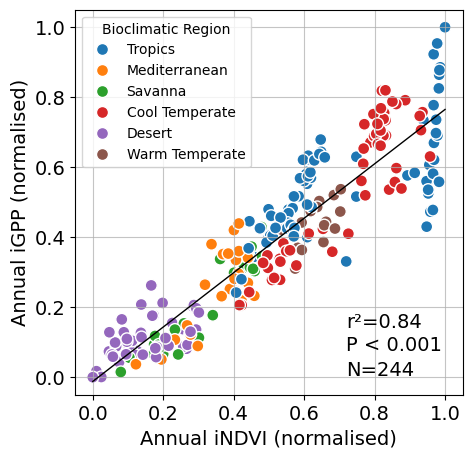

In [48]:
font=14
fig,ax = plt.subplots(1,1, figsize=(5,5))
varx='NDVI_normalised'
vary='GPP_normalised'
obs,pred = gdf_ts[varx].values, gdf_ts[vary].values
mask = ~np.isnan(obs) & ~np.isnan(pred)
slope, intercept, r_value, p_value, std_err = stats.linregress(obs[mask],pred[mask])
r2 = r_value**2

sb.scatterplot(data=gdf_ts, y=vary, x=varx,  hue='Bioclimatic Region', s=75, lw=1, ax=ax, legend=True) #
sb.regplot(data=gdf_ts, y=vary,x=varx, scatter=False, color='black', line_kws={'linewidth':'1'}, ax=ax, ci=None)
# sb.regplot(data=gdf_ts, y=vary, x=vary, color='black', scatter=False,ci=None, line_kws={'linestyle':'dashed'}, ax=ax)
ax.set_title(None)
ax.set_xlabel('Annual iNDVI (normalised)', fontsize=font)
ax.set_ylabel('Annual iGPP (normalised)',fontsize=font)
ax.grid(alpha=0.75)
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.text(.7, .175, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
        transform=ax.transAxes, fontsize=font)
ax.text(.7, .115, 'P < 0.001',
        transform=ax.transAxes, fontsize=font)
ax.text(.7, .05, 'N={:.3g}'.format(len(gdf_ts)),
        transform=ax.transAxes, fontsize=font)
ax.tick_params(axis='x', labelsize=font)
ax.tick_params(axis='y', labelsize=font)
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/AnnualGPP_vs_annualNDVI_bioclim.png',
               bbox_inches='tight', dpi=300)

## Partial correlations with GPP IOS

What part of the seasonal cycle controls GPP IOS?

In [49]:
pcorr_flux=[]
for k,v in flux_pheno.items():
    if len(v.index) < 5:
        pass
    else:
        # print(k, len(v.index))
        p_corr = pg.pairwise_corr(v.to_dataframe(),
                              columns=[['IOS'], ['vPOS','vEOS','vSOS' ,'LOS', 'SOS', 'POS', 'EOS']]) 
                
        p_corr = p_corr[['Y','r']].set_index('Y').transpose().reset_index(drop=True)
        p_corr['site'] = k
        p_corr['latitude'] = v.latitude.values.item()
        p_corr['longitude'] = v.longitude.values.item()
        pcorr_flux.append(p_corr)
pcorr_flux = pd.concat(pcorr_flux).reset_index(drop=True)
pcorr_flux.head(3)

Y,vPOS,vEOS,vSOS,LOS,SOS,POS,EOS,site,latitude,longitude
0,0.624466,0.497386,0.762870,0.543614,-0.675857,0.283156,0.108642,DalyUncleared,-14.159200,131.388100
1,0.428863,0.133888,0.375303,0.972596,0.364877,0.567908,-0.296511,CowBay,-16.238189,145.427150
2,0.720679,0.226423,0.204243,0.962431,0.686340,0.728221,-0.147050,RobsonCreek,-17.117469,145.630137


In [50]:
pcorr_flux = gpd.GeoDataFrame(
    pcorr_flux, geometry=gpd.points_from_xy(pcorr_flux.longitude, pcorr_flux.latitude))

pcorr_flux.crs = gdf.crs

pcorr_flux = pcorr_flux.sjoin(gdf, how="left").drop(['bioclimatic_regions', 'index_right'],axis=1)
pcorr_flux.loc[pcorr_flux['site'] == 'CapeTribulation', ['region_name']] = 'Tropics'
pcorr_flux.loc[pcorr_flux['site'] == 'CowBay', ['region_name']] = 'Tropics'

pcorr_flux['highest correlated'] = pcorr_flux[['vPOS','vEOS','vSOS' ,'LOS', 'SOS', 'POS', 'EOS']].abs().T.idxmax()

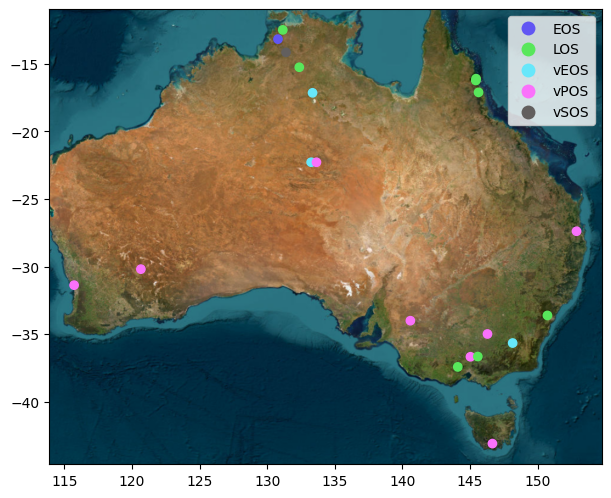

In [51]:
categories = ['vPOS','vSOS','vEOS' ,'SOS', 'POS', 'EOS', 'LOS']
colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

fig,ax = plt.subplots(1,1, figsize=(6,6), sharey=True, layout='constrained')
im = pcorr_flux.plot(column='highest correlated', legend=True, cmap=cmap, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)

# axins1 = inset_axes(ax, width="65%",height="5%",loc="lower left", borderpad=2)
# cbar = fig.colorbar(im, cax=axins1, orientation='horizontal') # ticks=[0.25,0.75]
# cbar.ax.set_xticklabels(['vPOS','vSOS','vEOS' ,'SOS', 'POS', 'EOS', 'LOS']);

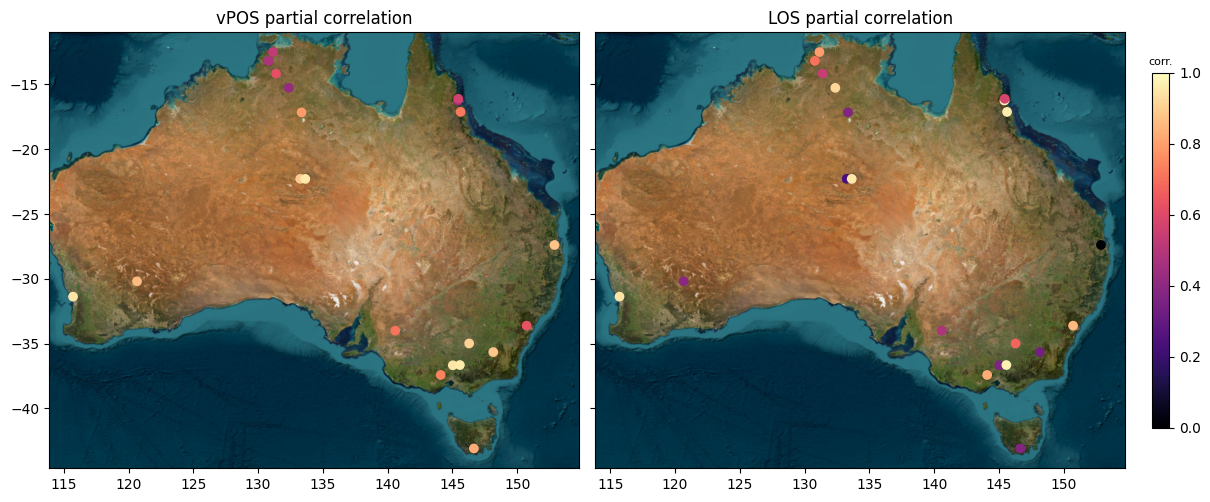

In [53]:
fig,ax = plt.subplots(1,2, figsize=(12,6), sharey=True, layout='constrained')
pcorr_flux.plot(column='vPOS', legend=False, cmap='magma', ax=ax[0], vmin=0, vmax=1)
ctx.add_basemap(ax[0], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
ax[0].set_title('vPOS partial correlation')
# label polygons
# pcorr_flux.apply(lambda x: ax[0].annotate(text=f'{x.site}',
#                         xy=x.geometry.centroid.coords[0], 
#                         xytext=(x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1]+1.5),
#                         ha='center', fontsize=10), axis=1)

pcorr_flux.plot(column='LOS', legend=False, cmap='magma', ax=ax[1], vmin=0, vmax=1)
ctx.add_basemap(ax[1], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
ax[1].set_title('LOS partial correlation')

norm = colors.Normalize(vmin=0, vmax=1)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='magma')
ax_cbar = fig.colorbar(cbar, ax=ax[1], shrink=0.6)
ax_cbar.ax.set_title('corr.', fontsize=8);

## NDVI's phenometrics correlation with iGPP

How does vPOS and LOS correlate with annual summed GPP at the flux towers?

Need to get the NDVI phenometrics paired up with annual GPP...

In [54]:
r='HowardSprings'
s=str(int(ndvi_pheno[r].POS_year.values[0][0][0].item()))
e=str(int(ndvi_pheno[r].POS_year.values[0][0][-1].item()))

trimmed_gpp = annual_gpp[r].sel(year=slice(str(s),str(e)))
trimmed_gpp['year'] = range(0,len(trimmed_gpp.year))
trimmed_gpp = trimmed_gpp.rename({'year':'index'})

ndvi_pheno_with_gpp = ndvi_pheno[r].squeeze()
ndvi_pheno_with_gpp['GPP'] = trimmed_gpp

In [55]:
pcorr_gpp_ndvi = pg.pairwise_corr(ndvi_pheno_with_gpp.to_dataframe(),
                    columns=[['GPP'], ['vPOS','vEOS','vSOS' ,'LOS', 'SOS', 'POS', 'EOS']]) 

pcorr_gpp_ndvi = pcorr_gpp_ndvi[['Y','r']].set_index('Y').transpose().reset_index(drop=True)
pcorr_gpp_ndvi['site'] = r
pcorr_gpp_ndvi['highest correlated'] = pcorr_gpp_ndvi[['vPOS','vEOS','vSOS' ,'LOS', 'SOS', 'POS', 'EOS']].abs().T.idxmax()
pcorr_gpp_ndvi

Y,vPOS,vEOS,vSOS,LOS,SOS,POS,EOS,site,highest correlated
0,0.18021,0.330083,0.247383,-0.043427,-0.10234,0.30106,-0.143039,HowardSprings,vEOS
